In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Chargement des datasets

In [5]:
X_test = pd.read_csv("X_test_update.csv", index_col=0)
X_train = pd.read_csv("X_train_update.csv", index_col = 0)

In [6]:
X_train.head()

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


Il y a énormément de valuers manquantes pour la variable description.

In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13812 entries, 84916 to 98727
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  13812 non-null  object
 1   description  8926 non-null   object
 2   productid    13812 non-null  int64 
 3   imageid      13812 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 539.5+ KB


In [9]:
y_train = pd.read_csv("Y_train_CVw08PX.csv", index_col=0)

In [10]:
y_train.head()

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [11]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


In [12]:
print(len(y_train.value_counts()))

27


Il y a 27 Product type codes différents à prédire.

In [ ]:
# prompt: déplacerle fichier images.zip dans le dossier /content

import shutil

# Source path of the zip file in Google Drive
source_path = "/content/drive/MyDrive/Alternance_Datascientest/Projet_DS/images.zip"  # Replace with the actual path

# Destination path in /content
destination_path = "/content/images.zip"


# Check if the source file exists
if os.path.exists(source_path):
    try:
        shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
        print(f"File '{source_path}' successfully copied to '{destination_path}'")
    except shutil.SameFileError:
        print(f"Source and destination represent the same file.")
    except PermissionError:
        print(f"Permission denied when trying to copy '{source_path}'.")
    except Exception as e:  # Handle other potential errors
        print(f"An error occurred during file copy: {e}")
else:
    print(f"Source file '{source_path}' not found.")

File '/content/drive/MyDrive/Alternance_Datascientest/Projet_DS/images.zip' successfully copied to '/content/images.zip'


In [ ]:
os.chdir("/content")

In [ ]:
# prompt: unzip le fichier /content/images.zip

!unzip /content/images.zip


Les images sont toutes de tailles (500,500,3)

### Exploration des images

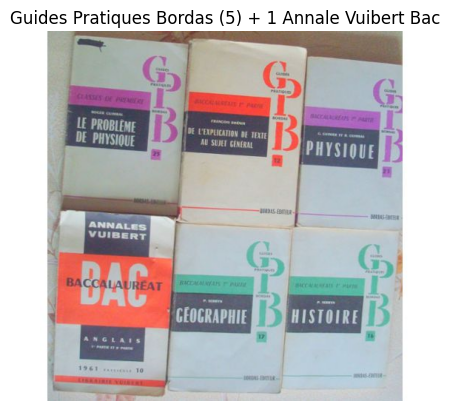

prdtypecode:  2403


In [ ]:
# Relancez la cellule pour afficher une image différente
row = np.random.randint(len(X_train))
plt.imshow(plt.imread(f"images/image_train/image_{X_train.iloc[row]['imageid']}_product_{X_train.iloc[row]['productid']}.jpg", format="jpg"))
plt.title(f"{X_train.iloc[row]['designation']}")
plt.axis("off")
plt.show()
print("prdtypecode: ",y_train.prdtypecode[row])

In [ ]:
img = plt.imread(f"images/image_train/image_{X_train.iloc[row]['imageid']}_product_{X_train.iloc[row]['productid']}.jpg")
img.reshape(1,-1).shape

(1, 750000)

In [ ]:
imgs: np.ndarray
imgs = None
for img_path in os.listdir("images/image_train"):
    img = plt.imread(fname=f"images/image_train/{img_path}", format="jpg")
    img_flat = img.reshape(1,-1)
    if imgs is None:
        imgs = img_flat
    else:
        imgs = np.concatenate((imgs, img_flat), axis=0)
print(imgs.shape)

### Visualisation et exploration des données textuelles

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

def generate_wordcloud(X_train, y_train, categories, colormap='viridis'):
    """
    Generates a word cloud with the 5 most redundant words for each category,
    using distinct colors from the specified colormap.

    Args:
        X_train (pd.DataFrame): DataFrame containing the 'description' column.
        y_train (pd.DataFrame): DataFrame containing the 'prdtypecode' column.
        categories (list): List of product type codes to include.
        colormap (str): Name of the matplotlib colormap to use.
    """

    # Create a color dictionary for each category (0-255 for WordCloud)
    colors = plt.get_cmap(colormap)(np.linspace(0, 1, len(categories)))
    category_colors_wordcloud = {cat: tuple(int(round(c * 255)) for c in color[:3])
                                 for cat, color in zip(categories, colors)}

    # Create a separate color dictionary for the legend (0-1 for matplotlib)
    category_colors_legend = {cat: color[:3]
                              for cat, color in zip(categories, colors)}

    all_words = []

    for category in categories:
        # Merge, drop NA, and filter by category
        merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
        merged_df = merged_df.dropna(subset=['description'])
        category_df = merged_df[merged_df['prdtypecode'] == category]

        if category_df.empty:
            print(f"No descriptions found for category '{category}'.")
            continue

        # Combine descriptions, preprocess, and count words
        text = " ".join(category_df['description'].astype(str))
        stop_words = set(stopwords.words('french'))
        lemmatizer = WordNetLemmatizer()

        words = text.lower().split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]

        # Get the 5 most common words
        word_counts = Counter(words)
        top_words = dict(word_counts.most_common(5))
        for word, count in top_words.items():
            all_words.append({'word': word, 'size': count, 'color': category_colors_wordcloud[category], 'category': category})
        # ...

    # Create WordCloud object (using category_colors_wordcloud)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          color_func=lambda word, **kwargs: all_words[[w['word'] for w in all_words].index(word)]['color'])

    # Generate word cloud from all_words
    wordcloud.generate_from_frequencies({w['word']: w['size'] for w in all_words})

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Categories")

    # Add legend (using category_colors_legend)
    # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
    #                               markerfacecolor=color, markersize=10)
    #                    for cat, color in category_colors_legend.items()]
    # plt.legend(handles=legend_elements, title="Categories", loc='upper left')

    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


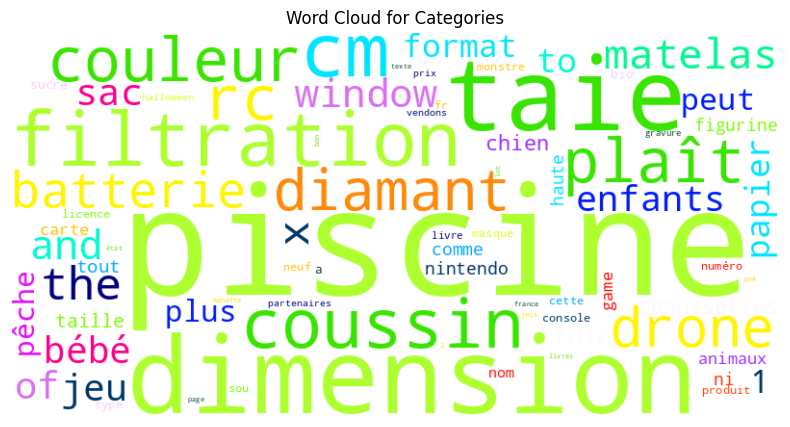

In [69]:
generate_wordcloud(X_train,y_train,y_train.prdtypecode.unique(),colormap='gist_ncar')

### Wordcloud par catégorie

In [65]:
def generate_categorical_wordcloud(X_train, y_train, category):
    """
    Generates a word cloud from the 'description' column of X_train,
    filtered by a specific category in the 'prdtypecode' column of y_train.

    Args:
        X_train (pd.DataFrame): DataFrame containing the 'description' column.
        y_train (pd.DataFrame): DataFrame containing the 'prdtypecode' column.
        category (str): The product type code to filter by.
    """
    # Merge X_train and y_train based on the common index
    merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)

    # Remove rows with missing descriptions
    merged_df = merged_df.dropna(subset=['description'])

    # Filter by category
    category_df = merged_df[merged_df['prdtypecode'] == category]

    if category_df.empty:
        print(f"No descriptions found for category '{category}'.")
        return

    # Combine all descriptions into a single string
    text = " ".join(category_df['description'].astype(str))

    # Preprocess the text
    stop_words = set(stopwords.words('french')) # Assuming French text
    lemmatizer = WordNetLemmatizer()

    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]
    processed_text = " ".join(words)

    # Create and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Category: {category}")
    plt.show()

In [27]:
# Affichage des catégories pour pouvoir explorer les différents nuages de mots
print(y_train.prdtypecode.unique())

[  10 2280   50 1280 2705 2522 2582 1560 1281 1920 2403 1140 2583 1180
 1300 2462 1160 2060   40   60 1320 1302 2220 2905 2585 1940 1301]


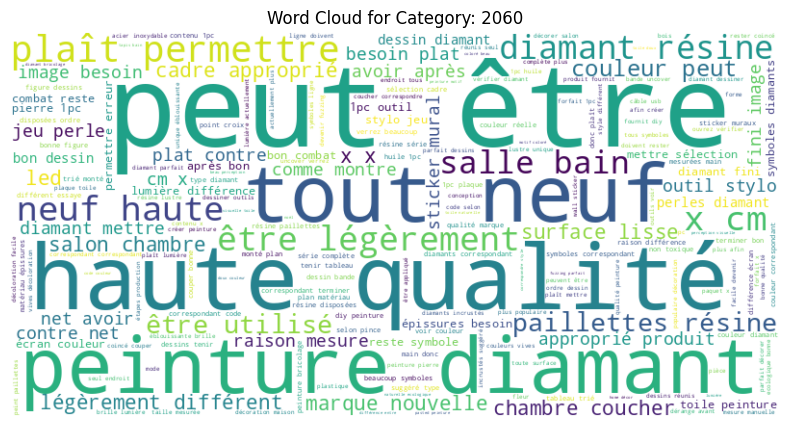

In [67]:
generate_categorical_wordcloud(X_train,y_train,category = 2060)

In [61]:
!pip install plotly
import plotly.graph_objects as go
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib.pyplot


nltk.download('stopwords')
nltk.download('wordnet')

def generate_interactive_wordcloud(X_train, y_train, categories, colormap='viridis'):
    """
    Generates an interactive word cloud with Plotly, allowing category selection.

    Args:
        X_train (pd.DataFrame): DataFrame containing the 'description' column.
        y_train (pd.DataFrame): DataFrame containing the 'prdtypecode' column.
        categories (list): List of product type codes to include.
        colormap (str): Name of the matplotlib colormap to use.
    """

    # Create a color dictionary for each category
    colors = plt.get_cmap(colormap)(np.linspace(0, 1, len(categories))) # Use plt.get_cmap
    category_colors = {cat: tuple(int(round(c * 255)) for c in color[:3])
                      for cat, color in zip(categories, colors)}

    all_words = []

    for category in categories:
        # Merge, drop NA, and filter by category
        merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
        merged_df = merged_df.dropna(subset=['description'])
        category_df = merged_df[merged_df['prdtypecode'] == category]

        if category_df.empty:
            print(f"No descriptions found for category '{category}'.")
            continue

        # Combine descriptions, preprocess, and count words
        text = " ".join(category_df['description'].astype(str))
        stop_words = set(stopwords.words('french'))
        lemmatizer = WordNetLemmatizer()

        words = text.lower().split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]

        # Get the 5 most common words
        word_counts = Counter(words)
        top_words = dict(word_counts.most_common(5))

        for word, count in top_words.items():
            all_words.append({'word': word, 'size': count, 'color': category_colors[category], 'category': category})

    # Create Plotly scatter plot
    fig = go.Figure()

    for word_data in all_words:
        # Convert category to string for the 'name' property
        category_name = str(word_data['category'])
        fig.add_trace(go.Scatter(
            x=[0],  # All words at x=0 to stack them vertically
            y=[0],  # All words at y=0 to stack them horizontally
            mode='text',
            text=[word_data['word']],
            textfont={'size': word_data['size'] * 5,  # Scale size for visual effect
                      'color': f'rgb{word_data["color"]}'},
            name=category_name,  # Use the string version of category
            visible=True  # Initially all words are visible
        ))

    # Update layout for better appearance
    fig.update_layout(
        title="Interactive Word Cloud",
        xaxis={'showgrid': False, 'zeroline': False, 'visible': False},
        yaxis={'showgrid': False, 'zeroline': False, 'visible': False},
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                active=0,
                x=0,
                y=1.1,
                buttons=list([
                    dict(label="All",
                         method="update",
                         args=[{"visible": [True] * len(all_words)},
                               {"title": "All Categories"}]),
                    *[dict(label=str(cat), # Convert category to string for the label
                           method="update",
                           args=[{"visible": [w['category'] == cat for w in all_words]},
                                 {"title": f"Category: {cat}"}]
                          ) for cat in categories]

                ])
            )
        ]
    )

    fig.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [62]:
generate_interactive_wordcloud(X_train,y_train,y_train.prdtypecode.unique(),colormap='viridis')